####Ví dụ 1

######Cách 1

In [19]:
# generate data
# list of points
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
np.random.seed(21)
from matplotlib.backends.backend_pdf import PdfPages

means = [[2, 2], [4, 1]]
cov = [[.3, .2], [.2, .3]]
N = 10
X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)
X1[-1, :] = [2.7, 2]
X0[-1, :] = [4.5, 1.2]
X = np.concatenate((X0.T, X1.T), axis = 1)
y = np.concatenate((np.ones((1, N)), -1*np.ones((1, N))), axis = 1)

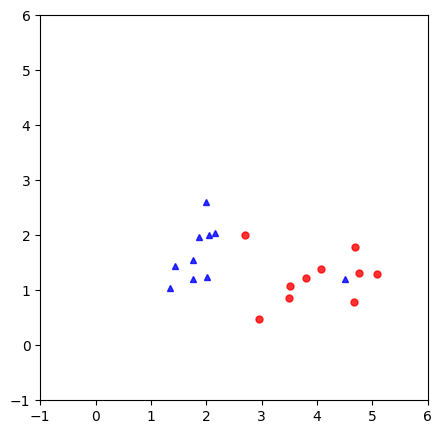

In [20]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 5))
ani = plt.cla()
#plot points
ani = plt.plot(X0.T[0, :], X0.T[1, :], 'b^', markersize = 5, alpha = .8)
ani = plt.plot(X1.T[0, :], X1.T[1, :], 'ro', markersize = 5, alpha = .8)
ani = plt.axis([-1 , 6, -1, 6])

In [21]:
!pip install cvxopt

In [22]:

from cvxopt import matrix, solvers
C = 100
# build K
V = np.concatenate((X0.T, -X1.T), axis = 1)
# K ~ P in lib cvxopt.qp
K = matrix(V.T.dot(V))

q = matrix(-np.ones((2*N, 1)))
# build A, b, G, h
G = matrix(np.vstack((-np.eye(2*N), np.eye(2*N))))

h = matrix(np.vstack((np.zeros((2*N, 1)), C*np.ones((2*N, 1)))))
A = matrix(y.reshape((-1, 2*N)))
b = matrix(np.zeros((1, 1)))
solvers.options['show_progress'] = False
sol = solvers.qp(K, q, G, h, A, b)

l = np.array(sol['x'])
print('lambda = \n', l.T)

lambda = 
 [[1.23267347e-07 4.85674336e+01 9.99999981e+01 1.57381885e-07
  1.40373846e-07 5.28974755e-08 4.87560151e-07 1.81225362e-07
  9.27217960e-08 1.00000000e+02 9.01112775e-08 5.15612516e-08
  3.58687179e-07 3.18585409e-07 7.07041178e-07 9.76857085e+01
  6.09091270e-08 5.08817211e+01 1.76779299e-06 9.99999999e+01]]


In [23]:
S = np.where(l > 1e-5)[0] # support set
S2 = np.where(l < .999*C)[0]

M = [val for val in S if val in S2] # intersection of two lists

XT = X.T # we need each column to be one data point in this alg
VS = V[:, S]
lS = l[S]
# Access all rows (which is just the first row) and the columns specified by M
yM = y[:, M]

In [24]:
# XM = XT[:, M] # Original line causing error
# XM = XT[M, :] # Select rows based on indices in M
XM = XT[M, :].T # Select rows based on indices in M and then transpose

w_dual = VS.dot(lS).reshape(-1, 1)
b_dual = np.mean(yM.T - w_dual.T.dot(XM))
print(w_dual.T, b_dual)

[[-1.06640598  1.01378208]] 1.662390577002948


######Cách 2

In [25]:
X0_bar = np.vstack((X0.T, np.ones((1, N)))) # extended data
X1_bar = np.vstack((X1.T, np.ones((1, N)))) # extended data
Z = np.hstack((X0_bar, - X1_bar)) # as in (22)
lam = 1./C
def cost(w):
  u = w.T.dot(Z) # as in (23)
  return (np.sum(np.maximum(0, 1 - u)) + \
  .5*lam*np.sum(w*w)) - .5*lam*w[-1]*w[-1] # no bias
def grad(w):
  u = w.T.dot(Z) # as in (23)
  H = np.where(u < 1)[1]
  ZS = Z[:, H]
  g = (-np.sum(ZS, axis = 1, keepdims = True) + lam*w)
  g[-1] -= lam*w[-1] # no weight decay on bias
  return g
eps = 1e-6

In [26]:
def grad_descent(w0, eta):
  w = w0
  it = 0
  while it < 100000:
    it = it + 1
    g = grad(w)
    w -= eta*g
    if (it % 10000) == 1:
      print('iter %d' %it + ' cost: %f' %cost(w))
    if np.linalg.norm(g) < 1e-5:
      break
  return w

In [27]:
w0 = np.random.randn(X0_bar.shape[0], 1)
w = grad_descent(w0, 0.001)
w_hinge = w[:-1].reshape(-1, 1)
b_hinge = w[-1]
print(w_hinge.T, b_hinge)

iter 1 cost: 24.312820


<ipython-input-26-7a67c1bc640d>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('iter %d' %it + ' cost: %f' %cost(w))


iter 10001 cost: 4.963527
iter 20001 cost: 4.969327
iter 30001 cost: 4.961336
iter 40001 cost: 4.961370
iter 50001 cost: 4.961404
iter 60001 cost: 4.961438
iter 70001 cost: 4.969322
iter 80001 cost: 4.969296
iter 90001 cost: 4.969269
[[-1.07049082  0.99874462]] [1.68169917]


######Cách 3

In [28]:
from sklearn.svm import SVC
# Copy and put code for generate data here
y1 = y.reshape((2*N,))
X1 = X.T # each sample is one row
clf = SVC(kernel = 'linear', C = 100) # use the same C
# if C is small, method will be “SoftMagin SVM”,
# if C is large enough, method is near to hard margin
clf.fit(X1, y1)

w = clf.coef_
w0 = clf.intercept_
print('w = ', w)
print('b = ', w0)

w =  [[-1.06600888  1.01354038]]
b =  [1.66151836]


####Bài tập thực hành 1

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import pandas as pd # For loading CSV files in later exercises

# Function to plot decision boundary (optional, can be adapted from Hard Margin SVM example)
def plot_decision_boundary(X, y, model, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='k')

    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                         np.linspace(ylim[0], ylim[1], 50))
    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
                linestyles=['--', '-', '--'])
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.2) # Filled decision regions


    # Highlight support vectors
    if hasattr(model, 'support_vectors_'):
        sv = model.support_vectors_
        plt.scatter(sv[:, 0], sv[:, 1], s=100, facecolors='none', edgecolors='k')

    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

def evaluate_model(y_true, y_pred, C_value, dataset_name="Training"):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    print(f"--- Evaluation for C={C_value} on {dataset_name} data ---")
    print(f"Accuracy: {acc:.4f}")
    print(f"Confusion Matrix:\n{cm}")
    return acc, cm

Generated data for Bài tập thực hành 1:
X_ex1 shape: (200, 2)
y_ex1 shape: (200,)
First 5 samples of X_ex1:
 [[2.05084632 2.00111793]
 [1.76011705 1.19808615]
 [2.00990941 1.24470291]
 [2.15538393 2.05048046]
 [1.43875123 1.43310473]]
First 10 labels of y_ex1: [1 1 1 1 1 1 1 1 1 1]
Last 10 labels of y_ex1: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


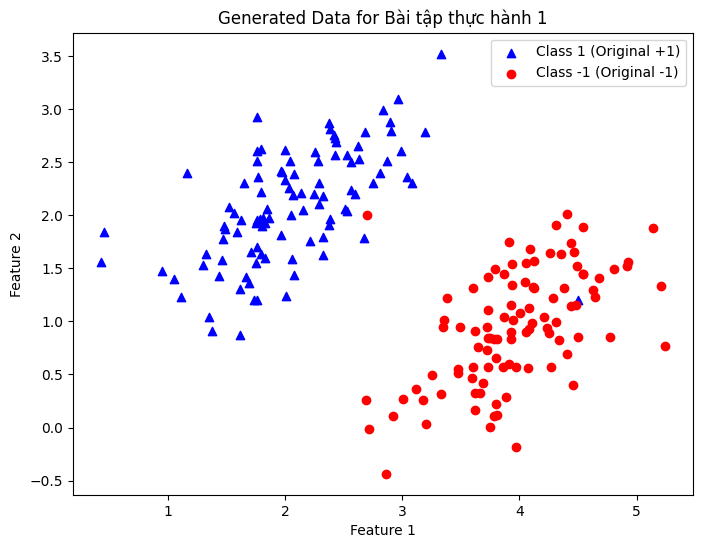

In [30]:

# Data generation adapted from "Ví dụ 1"
np.random.seed(21)
means = [[2, 2], [4, 1]]
cov = [[0.3, 0.2], [0.2, 0.3]] # Corrected covariance matrix structure
N = 100 # As per text[cite: 2], though example code used N=10[cite: 1]. Using N=100 for a richer dataset.
        # If N=10 is desired as in the code snippet, change this value.

X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)
X1[-1, :] = [2.7, 2]
X0[-1, :] = [4.5, 1.2]
X = np.concatenate((X0.T, X1.T), axis = 1)

# Create X_sklearn (samples, features) and y_sklearn (samples,)
X_ex1 = np.vstack((X0, X1))
y_ex1 = np.array([1]*N + [-1]*N) # Using 1 and -1 for classes as typical in SVM theory


print("Generated data for Bài tập thực hành 1:")
print("X_ex1 shape:", X_ex1.shape)
print("y_ex1 shape:", y_ex1.shape)
print("First 5 samples of X_ex1:\n", X_ex1[:5])
print("First 10 labels of y_ex1:", y_ex1[:10])
print("Last 10 labels of y_ex1:", y_ex1[-10:])

# Optional: Visualize the generated data
plt.figure(figsize=(8, 6))
plt.scatter(X_ex1[:N, 0], X_ex1[:N, 1], color='b', marker='^', label='Class 1 (Original +1)')
plt.scatter(X_ex1[N:, 0], X_ex1[N:, 1], color='r', marker='o', label='Class -1 (Original -1)')
plt.title("Generated Data for Bài tập thực hành 1")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()


--- Bài tập thực hành 1, Phần 1 (C=100) ---
Calculated weights for C=100:
w: [-1.42778364  1.44987365]
w0 (b): 2.0647545771419744
--- Evaluation for C=100 on Generated Data (X_ex1) data ---
Accuracy: 0.9900
Confusion Matrix:
[[99  1]
 [ 1 99]]


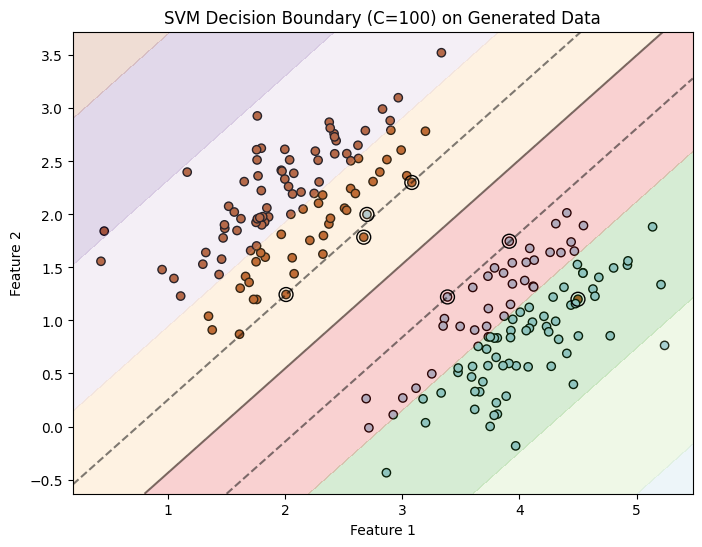

In [31]:
print("\n--- Bài tập thực hành 1, Phần 1 (C=100) ---")
C_initial = 100
clf_ex1_initial = SVC(kernel='linear', C=C_initial)
clf_ex1_initial.fit(X_ex1, y_ex1)

# Get w and w0 (b)
w_initial = clf_ex1_initial.coef_[0]
w0_initial = clf_ex1_initial.intercept_[0]
print(f"Calculated weights for C={C_initial}:")
print(f"w: {w_initial}")
print(f"w0 (b): {w0_initial}")

# Predict on the training data itself
y_pred_ex1_initial = clf_ex1_initial.predict(X_ex1)

# Evaluate
evaluate_model(y_ex1, y_pred_ex1_initial, C_initial, dataset_name="Generated Data (X_ex1)")

# Optional: Plot decision boundary
plot_decision_boundary(X_ex1, y_ex1, clf_ex1_initial, f"SVM Decision Boundary (C={C_initial}) on Generated Data")

In [32]:
print("\n--- Bài tập thực hành 1, Phần 2 (Varying C) ---")
C_values_ex1 = [1000, 200, 10, 1, 0.5] # Added C=1 for comparison

results_ex1 = {}

for C_val in C_values_ex1:
    print(f"\n--- Processing for C = {C_val} ---")
    clf_ex1_varying_C = SVC(kernel='linear', C=C_val)
    clf_ex1_varying_C.fit(X_ex1, y_ex1)

    w = clf_ex1_varying_C.coef_[0]
    w0 = clf_ex1_varying_C.intercept_[0]

    print(f"Bộ hệ số cho C={C_val}:")
    print(f"  w: {w}")
    print(f"  w0 (b): {w0}")

    y_pred_ex1_varying_C = clf_ex1_varying_C.predict(X_ex1)
    acc, cm = evaluate_model(y_ex1, y_pred_ex1_varying_C, C_val, dataset_name="Generated Data (X_ex1)")

    results_ex1[C_val] = {'w': w, 'w0': w0, 'accuracy': acc, 'confusion_matrix': cm}

    # Optional: Plot decision boundary for each C
    # plot_decision_boundary(X_ex1, y_ex1, clf_ex1_varying_C, f"SVM Decision Boundary (C={C_val}) on Generated Data")

print("\nSummary of results for Bài tập thực hành 1, Phần 2:")
for C_val, res in results_ex1.items():
    print(f"C = {C_val}: w = {res['w']}, w0 = {res['w0']:.4f}, Accuracy = {res['accuracy']:.4f}")
    print(f"  Confusion Matrix:\n{res['confusion_matrix']}")


--- Bài tập thực hành 1, Phần 2 (Varying C) ---

--- Processing for C = 1000 ---
Bộ hệ số cho C=1000:
  w: [-1.42706137  1.45148718]
  w0 (b): 2.060170026394424
--- Evaluation for C=1000 on Generated Data (X_ex1) data ---
Accuracy: 0.9900
Confusion Matrix:
[[99  1]
 [ 1 99]]

--- Processing for C = 200 ---
Bộ hệ số cho C=200:
  w: [-1.4275913   1.45062282]
  w0 (b): 2.0630226502267615
--- Evaluation for C=200 on Generated Data (X_ex1) data ---
Accuracy: 0.9900
Confusion Matrix:
[[99  1]
 [ 1 99]]

--- Processing for C = 10 ---
Bộ hệ số cho C=10:
  w: [-1.31258548  1.33275939]
  w0 (b): 1.9792164363986886
--- Evaluation for C=10 on Generated Data (X_ex1) data ---
Accuracy: 0.9900
Confusion Matrix:
[[99  1]
 [ 1 99]]

--- Processing for C = 1 ---
Bộ hệ số cho C=1:
  w: [-1.29210017  1.18791178]
  w0 (b): 2.118320554992923
--- Evaluation for C=1 on Generated Data (X_ex1) data ---
Accuracy: 0.9900
Confusion Matrix:
[[99  1]
 [ 1 99]]

--- Processing for C = 0.5 ---
Bộ hệ số cho C=0.5:
  w

####Bài tập thực hành 2

In [33]:
print("\n\n--- Bài tập thực hành 2: Wisconsin Breast Cancer Dataset ---")
from sklearn.datasets import load_breast_cancer

# Load data [cite: 30]
cancer_data = load_breast_cancer()
X_cancer, y_cancer = cancer_data.data, cancer_data.target

# The target in sklearn's breast cancer dataset is 0 (malignant) and 1 (benign).
# SVM typically works with 1 and -1. Sklearn's SVC handles 0/1 fine,
# but if we wanted to strictly follow SVM formulation for manual calcs, we might map:
# Malignant (target 0) -> class -1 (or 1)
# Benign (target 1) -> class 1 (or -1)
# Let's map 0 to -1 and 1 to 1 for consistency if we were comparing to theory.
# However, SVC handles (0,1) automatically. For simplicity, we'll use original 0,1.
# If strict -1,1 is needed: y_cancer = np.array([-1 if x == 0 else 1 for x in y_cancer])

print("Breast Cancer Dataset:")
print("X_cancer shape:", X_cancer.shape) # [cite: 27] (569 samples, 30 features)
print("y_cancer shape:", y_cancer.shape)
print("Class distribution:", np.bincount(y_cancer)) # Benign (class 1) 357, Malignant (class 0) 212 [cite: 28]

# Split data into training and testing sets
X_train_cancer, X_test_cancer, y_train_cancer, y_test_cancer = train_test_split(
    X_cancer, y_cancer, test_size=0.3, random_state=42, stratify=y_cancer
)

# Scale features: SVM is sensitive to feature scaling
scaler_cancer = StandardScaler()
X_train_cancer_scaled = scaler_cancer.fit_transform(X_train_cancer)
# Use the transform method of the scaler_cancer object
X_test_cancer_scaled = scaler_cancer.transform(X_test_cancer)

# Apply SVM (using C=100 as a default, similar to example [cite: 7, 21])
# You can try other C values from Bài tập thực hành 1
C_cancer = 100  # Or choose another value, e.g., 1.0 or 10
print(f"\n--- Training SVM on Breast Cancer data with C={C_cancer} ---")

clf_cancer = SVC(kernel='linear', C=C_cancer)
clf_cancer.fit(X_train_cancer_scaled, y_train_cancer)

# Get w and w0 (b)
w_cancer = clf_cancer.coef_[0]
w0_cancer = clf_cancer.intercept_[0]
print(f"Calculated weights for C={C_cancer}:")
print(f"w (first 5 elements): {w_cancer[:5]}...") # Displaying only first 5 for brevity
print(f"w0 (b): {w0_cancer}")

# Evaluate on training data
print("\n--- Evaluation on Training Data (Breast Cancer) ---")
y_pred_train_cancer = clf_cancer.predict(X_train_cancer_scaled)
evaluate_model(y_train_cancer, y_pred_train_cancer, C_cancer, dataset_name="Cancer Train")

# Evaluate on testing data
print("\n--- Evaluation on Test Data (Breast Cancer) ---")
y_pred_test_cancer = clf_cancer.predict(X_test_cancer_scaled)
evaluate_model(y_test_cancer, y_pred_test_cancer, C_cancer, dataset_name="Cancer Test")




--- Bài tập thực hành 2: Wisconsin Breast Cancer Dataset ---
Breast Cancer Dataset:
X_cancer shape: (569, 30)
y_cancer shape: (569,)
Class distribution: [212 357]

--- Training SVM on Breast Cancer data with C=100 ---
Calculated weights for C=100:
w (first 5 elements): [ 2.84021483 -3.05435434  1.37191358 -1.03888291 -2.0709684 ]...
w0 (b): -2.676827452035062

--- Evaluation on Training Data (Breast Cancer) ---
--- Evaluation for C=100 on Cancer Train data ---
Accuracy: 1.0000
Confusion Matrix:
[[148   0]
 [  0 250]]

--- Evaluation on Test Data (Breast Cancer) ---
--- Evaluation for C=100 on Cancer Test data ---
Accuracy: 0.9415
Confusion Matrix:
[[ 61   3]
 [  7 100]]


(0.9415204678362573,
 array([[ 61,   3],
        [  7, 100]]))

####Ví dụ 2

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

print("\n\n--- Ví dụ 2 (Bài tập tự giải): Sonar Dataset ---")

# URL chứa dữ liệu Sonar (không có header)
sonar_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data"

# Đọc trực tiếp từ URL
sonar_df = pd.read_csv(sonar_url, header=None)
print("Sonar dataset loaded successfully from URL.")
print("Shape of Sonar dataset:", sonar_df.shape)  # Expected: (208, 61)

# Tách đặc trưng và nhãn
X_sonar = sonar_df.iloc[:, :-1].values
y_sonar_raw = sonar_df.iloc[:, -1].values

# Chuyển nhãn: 'M' → 1, 'R' → -1
y_sonar = np.array([1 if label == 'M' else -1 for label in y_sonar_raw])

print("Sonar data shapes after processing:")
print("X_sonar shape:", X_sonar.shape)
print("y_sonar shape:", y_sonar.shape)
print("Unique labels in y_sonar:", np.unique(y_sonar, return_counts=True))

# Chia tập dữ liệu
X_train_sonar, X_test_sonar, y_train_sonar, y_test_sonar = train_test_split(
    X_sonar, y_sonar, test_size=0.3, random_state=42, stratify=y_sonar
)

# Chuẩn hóa dữ liệu
scaler_sonar = StandardScaler()
X_train_sonar_scaled = scaler_sonar.fit_transform(X_train_sonar)
X_test_sonar_scaled = scaler_sonar.transform(X_test_sonar)

# Huấn luyện mô hình SVM tuyến tính
C_sonar = 10.0
print(f"\n--- Training SVM on Sonar data with C={C_sonar} ---")

clf_sonar = SVC(kernel='linear', C=C_sonar)
clf_sonar.fit(X_train_sonar_scaled, y_train_sonar)

# Trích xuất trọng số
w_sonar = clf_sonar.coef_[0]
w0_sonar = clf_sonar.intercept_[0]
print(f"Calculated weights for C={C_sonar}:")
print(f"w (first 5 elements): {w_sonar[:5]}...")
print(f"w0 (b): {w0_sonar}")

# Đánh giá mô hình
def evaluate_model(y_true, y_pred, C, dataset_name=""):
    from sklearn.metrics import accuracy_score, confusion_matrix
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=[-1, 1])
    print(f"[{dataset_name}] Accuracy (C={C}): {acc:.4f}")
    print(f"[{dataset_name}] Confusion Matrix:")
    print(cm)

print("\n--- Evaluation on Training Data (Sonar) ---")
y_pred_train_sonar = clf_sonar.predict(X_train_sonar_scaled)
evaluate_model(y_train_sonar, y_pred_train_sonar, C_sonar, dataset_name="Sonar Train")

print("\n--- Evaluation on Test Data (Sonar) ---")
y_pred_test_sonar = clf_sonar.predict(X_test_sonar_scaled)
evaluate_model(y_test_sonar, y_pred_test_sonar, C_sonar, dataset_name="Sonar Test")




--- Ví dụ 2 (Bài tập tự giải): Sonar Dataset ---
Sonar dataset loaded successfully from URL.
Shape of Sonar dataset: (208, 61)
Sonar data shapes after processing:
X_sonar shape: (208, 60)
y_sonar shape: (208,)
Unique labels in y_sonar: (array([-1,  1]), array([ 97, 111]))

--- Training SVM on Sonar data with C=10.0 ---
Calculated weights for C=10.0:
w (first 5 elements): [ 1.14477459  0.36173013 -0.66747768  1.39065835 -1.27620509]...
w0 (b): 0.4016469279403256

--- Evaluation on Training Data (Sonar) ---
[Sonar Train] Accuracy (C=10.0): 1.0000
[Sonar Train] Confusion Matrix:
[[68  0]
 [ 0 77]]

--- Evaluation on Test Data (Sonar) ---
[Sonar Test] Accuracy (C=10.0): 0.7619
[Sonar Test] Confusion Matrix:
[[24  5]
 [10 24]]


#### Ví dụ 3

In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

print("\n\n--- Ví dụ 3 (Bài tập tự giải): Spambase Dataset ---")

# URL đến file spambase.data (không có header)
spambase_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"

# Đọc dữ liệu từ URL
spambase_df = pd.read_csv(spambase_url, header=None)
print("Spambase dataset loaded successfully from URL.")
print("Shape of Spambase dataset:", spambase_df.shape)  # Expected: (4601, 58)

# Tách đặc trưng và nhãn
X_spambase = spambase_df.iloc[:, :-1].values  # 57 features
y_spambase_raw = spambase_df.iloc[:, -1].values  # Label (1 = spam, 0 = not spam)

# Chuyển nhãn: 1 → 1, 0 → -1
y_spambase = np.array([1 if label == 1 else -1 for label in y_spambase_raw])

print("Spambase data shapes after processing:")
print("X_spambase shape:", X_spambase.shape)
print("y_spambase shape:", y_spambase.shape)
print("Unique labels in y_spambase:", np.unique(y_spambase, return_counts=True))

# Chia dữ liệu: 70% train, 30% test
X_train_spambase, X_test_spambase, y_train_spambase, y_test_spambase = train_test_split(
    X_spambase, y_spambase, test_size=0.3, random_state=42, stratify=y_spambase
)

# Chuẩn hóa đặc trưng
scaler_spambase = StandardScaler()
X_train_spambase_scaled = scaler_spambase.fit_transform(X_train_spambase)
X_test_spambase_scaled = scaler_spambase.transform(X_test_spambase)

# Huấn luyện SVM tuyến tính
C_spambase = 10.0
print(f"\n--- Training SVM on Spambase data with C={C_spambase} ---")

clf_spambase = SVC(kernel='linear', C=C_spambase, max_iter=10000)
clf_spambase.fit(X_train_spambase_scaled, y_train_spambase)

# Trích xuất w và w0 (b)
w_spambase = clf_spambase.coef_[0]
w0_spambase = clf_spambase.intercept_[0]
print(f"Calculated weights for C={C_spambase}:")
print(f"w (first 5 elements): {w_spambase[:5]}...")
print(f"w0 (b): {w0_spambase}")

# Hàm đánh giá
def evaluate_model(y_true, y_pred, C, dataset_name=""):
    from sklearn.metrics import accuracy_score, confusion_matrix
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=[-1, 1])
    print(f"[{dataset_name}] Accuracy (C={C}): {acc:.4f}")
    print(f"[{dataset_name}] Confusion Matrix:")
    print(cm)

# Đánh giá trên tập huấn luyện
print("\n--- Evaluation on Training Data (Spambase) ---")
y_pred_train_spambase = clf_spambase.predict(X_train_spambase_scaled)
evaluate_model(y_train_spambase, y_pred_train_spambase, C_spambase, dataset_name="Spambase Train")

# Đánh giá trên tập kiểm tra
print("\n--- Evaluation on Test Data (Spambase) ---")
y_pred_test_spambase = clf_spambase.predict(X_test_spambase_scaled)
evaluate_model(y_test_spambase, y_pred_test_spambase, C_spambase, dataset_name="Spambase Test")




--- Ví dụ 3 (Bài tập tự giải): Spambase Dataset ---
Spambase dataset loaded successfully from URL.
Shape of Spambase dataset: (4601, 58)
Spambase data shapes after processing:
X_spambase shape: (4601, 57)
y_spambase shape: (4601,)
Unique labels in y_spambase: (array([-1,  1]), array([2788, 1813]))

--- Training SVM on Spambase data with C=10.0 ---


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Calculated weights for C=10.0:
w (first 5 elements): [-0.14753158 -0.26070384 -0.08146255  0.12815059 -0.2051424 ]...
w0 (b): -0.3732341432712396

--- Evaluation on Training Data (Spambase) ---
[Spambase Train] Accuracy (C=10.0): 0.6273
[Spambase Train] Confusion Matrix:
[[ 870 1081]
 [ 119 1150]]

--- Evaluation on Test Data (Spambase) ---
[Spambase Test] Accuracy (C=10.0): 0.6162
[Spambase Test] Confusion Matrix:
[[354 483]
 [ 47 497]]


####ví dụ 5

In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

print("\n\n--- Ví dụ 5 (Bài tập tự giải): Graduate Admissions Dataset ---")


admission_df = pd.read_csv("/content/Admission_Predict_Ver1.1.csv")
print("Graduate Admissions dataset loaded successfully from URL.")
print("Shape of Admission dataset:", admission_df.shape)  # Thường là 500 dòng

# Dọn dẹp tên cột
admission_df.columns = admission_df.columns.str.strip()

# Tách đặc trưng và nhãn
X_admission = admission_df.drop(['Serial No.', 'Chance of Admit'], axis=1).values
y_admission_continuous = admission_df['Chance of Admit'].values

# Chuyển bài toán thành nhị phân: 1 nếu >= 0.75, ngược lại -1
threshold = 0.75
y_admission = np.array([1 if chance >= threshold else -1 for chance in y_admission_continuous])

print("Admission data shapes after processing:")
print("X_admission shape:", X_admission.shape)
print("y_admission shape:", y_admission.shape)
print(f"Unique labels in y_admission (threshold {threshold}):", np.unique(y_admission, return_counts=True))

# Bảo đảm có 2 lớp để phân loại
if len(np.unique(y_admission)) < 2:
    print(f"Warning: Only one class present after binarization with threshold {threshold}. Adjust threshold if needed.")
else:
    # Chia tập train/test
    X_train_adm, X_test_adm, y_train_adm, y_test_adm = train_test_split(
        X_admission, y_admission, test_size=0.3, random_state=42, stratify=y_admission
    )

    # Chuẩn hóa
    scaler_adm = StandardScaler()
    X_train_adm_scaled = scaler_adm.fit_transform(X_train_adm)
    X_test_adm_scaled = scaler_adm.transform(X_test_adm)

    # Huấn luyện SVM tuyến tính
    C_admission = 1.0
    print(f"\n--- Training SVM on Admission data with C={C_admission} (Threshold={threshold}) ---")
    clf_admission = SVC(kernel='linear', C=C_admission)
    clf_admission.fit(X_train_adm_scaled, y_train_adm)

    # Trích xuất tham số
    w_admission = clf_admission.coef_[0]
    w0_admission = clf_admission.intercept_[0]
    print(f"Calculated weights for C={C_admission}:")
    print(f"w (first 5 elements): {w_admission[:5]}...")
    print(f"w0 (b): {w0_admission}")

    # Hàm đánh giá
    def evaluate_model(y_true, y_pred, C, dataset_name=""):
        from sklearn.metrics import accuracy_score, confusion_matrix
        acc = accuracy_score(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred, labels=[-1, 1])
        print(f"[{dataset_name}] Accuracy (C={C}): {acc:.4f}")
        print(f"[{dataset_name}] Confusion Matrix:")
        print(cm)
        return acc, cm

    # Đánh giá SVM trên tập huấn luyện
    print("\n--- Evaluation on Training Data (Admission) ---")
    y_pred_train_adm = clf_admission.predict(X_train_adm_scaled)
    evaluate_model(y_train_adm, y_pred_train_adm, C_admission, dataset_name="Admission Train")

    # Đánh giá SVM trên tập kiểm tra
    print("\n--- Evaluation on Test Data (Admission) ---")
    y_pred_test_adm = clf_admission.predict(X_test_adm_scaled)
    evaluate_model(y_test_adm, y_pred_test_adm, C_admission, dataset_name="Admission Test")

    # So sánh với Logistic Regression
    print("\n--- Training Logistic Regression on Admission data (for comparison) ---")
    log_reg = LogisticRegression(solver='liblinear', random_state=42)
    log_reg.fit(X_train_adm_scaled, y_train_adm)

    print("\n--- Evaluation of Logistic Regression on Test Data (Admission) ---")
    y_pred_test_log_reg = log_reg.predict(X_test_adm_scaled)
    acc_log_reg, cm_log_reg = evaluate_model(y_test_adm, y_pred_test_log_reg, "N/A (LogReg)", dataset_name="Admission Test (LogReg)")
    print(f"Logistic Regression Test Accuracy: {acc_log_reg:.4f}")
    print(f"Logistic Regression Test Confusion Matrix:\n{cm_log_reg}")




--- Ví dụ 5 (Bài tập tự giải): Graduate Admissions Dataset ---
Graduate Admissions dataset loaded successfully from URL.
Shape of Admission dataset: (500, 9)
Admission data shapes after processing:
X_admission shape: (500, 7)
y_admission shape: (500,)
Unique labels in y_admission (threshold 0.75): (array([-1,  1]), array([282, 218]))

--- Training SVM on Admission data with C=1.0 (Threshold=0.75) ---
Calculated weights for C=1.0:
w (first 5 elements): [0.44169379 0.28160884 0.2364973  0.13353888 0.15186553]...
w0 (b): -0.44636350689165877

--- Evaluation on Training Data (Admission) ---
[Admission Train] Accuracy (C=1.0): 0.8857
[Admission Train] Confusion Matrix:
[[178  19]
 [ 21 132]]

--- Evaluation on Test Data (Admission) ---
[Admission Test] Accuracy (C=1.0): 0.9067
[Admission Test] Confusion Matrix:
[[79  6]
 [ 8 57]]

--- Training Logistic Regression on Admission data (for comparison) ---

--- Evaluation of Logistic Regression on Test Data (Admission) ---
[Admission Test (Log